# Adaptive response

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

here() starts at /Users/alzhang/Documents/projects/tfri_halo

Loading required package: ggpubr

Attaching package: 'survminer'

The following object is masked from 'package:survival':

    myeloma

here() starts at /Users/alzhang/Documents/projects/tfri_halo

In [ ]:
colorscheme_brewer <- function(x, palname) {
  a <- brewer.pal(length(unique(na.omit(x))), palname)
  names(a) <- unique(na.omit(sort(x)))
  return(a)
}


In [ ]:
# COLOR MAPS

palette_tilclust <- c('Low TIL'='#324376',
                      'High TIL'='#F76C5E')

palette_cohort <- c("Cross Canada"="#D90368",
                    "Historic Vancouver"="#7F95D1")

palette_nodes <- c("negative"="#E6EBE0", 
                   "positive"="#36C9C6", 
                   "not tested"="#696773")

palette_binary <- c('Yes'="#2E282A", 
                    'No'="#E7ECEF")
palette_tma <- c("10-005"="#88A096",
                 "10-006"="#BBAB8B",
                 "22-004"="#8A4F7D")

hist_mapping <- c("endometrioid (squamous)" = "endometrioid", 
                  "mixed endometrioid and serous" = "mixed", 
                  "mixed serous and moderately differentiated" = "mixed",
                  "undifferentiated" = "undiff/dediff",
                  "dedifferentiated" = "undiff/dediff")


In [ ]:
# Clinical
clinical_data_path <- here::here("data", "processed", "clinical_data.tsv")

# B & T 
bt_data_path <- here::here("data", "processed", "bt_labeled.tsv")

# Adaptive resistance 
ar_pheno_data_path <- here::here("data", "processed", "ar_pheno_labeled.tsv")
ar_area_data_path <- here::here("data", "processed", "ar_area_labeled.tsv")

# Angio (areas only now)
angio_data_path <- here::here("data", "processed", "angio_labeled.tsv")


In [ ]:
clinical <- read_tsv(clinical_data_path)


Rows: 374 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (19): cohort, patient_id, study_id, acc_num, tma, stage_full, grade_rev,...
dbl  (6): core_id, age_dx, age_surg, os_yrs, dss_yrs, pfs_yrs
lgl  (3): chemo, rt, brachy

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 731 Columns: 36
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): tma, row, acc_num, block, notes
dbl (31): sector, col, area_tumour_pct, area_stroma_pct, area_tissue_mm, are...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 720 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): tma, acc_num, block
dbl (19): sector, row, col, area_tumour_mm, area_stroma_mm, count_mac_pdl1ne...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 710 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): tma, acc_num, block
dbl (21): sector, row, col, area_tumour_mm, area_stroma_mm, area_pdl1pos_ido...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 718 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): tma, col, acc_num, block
dbl (5): sector, row, area_tumour_mm, area_stroma_mm, area_vessel_mm

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
# Remove redundant or useless columns
bt <- bt %>%
  select(-c(notes, area_tumour_pct, area_stroma_pct, area_tissue_mm, block)) %>%
  # Remove density columns
  select(-colnames(bt)[str_detect(colnames(bt), "^dens")])

ar_pheno <- ar_pheno %>%
  select(-c(block)) 

ar_area <- ar_area %>%
  select(-c(block)) 

angio <- angio %>%
  select(-c(block))

# Remove rows with no entries
bt_clean <- bt[complete.cases(bt),]
ar_pheno_clean <- ar_pheno[complete.cases(ar_pheno),]
ar_area_clean <- ar_area[complete.cases(ar_area),]
angio_clean <- angio[complete.cases(angio),]


In [ ]:
metatable_bt <- bt %>%
  dplyr::select(tma, acc_num) %>%
  mutate(`B & T` = TRUE,
         tma=str_replace_all(tma, "[AB]$", "")) %>%
  unique %>%
  rename(TMA=tma) %>%
  mutate(
    TMA = factor(TMA, levels = c("10-005", "10-006", "22-004"))
  )
  

metatable_angio <- angio %>%
  dplyr::select(tma, acc_num) %>%
  mutate(angiogenesis = TRUE,
         tma=str_replace_all(tma, "[AB]$", "")) %>%
  unique %>%
  rename(TMA=tma) %>%
  mutate(
    TMA = factor(TMA, levels = c("10-005", "10-006", "22-004"))
  )

metatable_ar <- ar_pheno %>%
  dplyr::select(tma, acc_num) %>%
  mutate(`Adaptive Resistance` = TRUE,
         tma=str_replace_all(tma, "[AB]$", "")) %>%
  unique %>%
  rename(TMA=tma) %>%
  mutate(
    TMA = factor(TMA, levels = c("10-005", "10-006", "22-004"))
  )

metatable_ar_area <- ar_area %>%
  dplyr::select(tma, acc_num) %>%
  mutate(`Adaptive Resistance` = TRUE,
         tma=str_replace_all(tma, "[AB]$", "")) %>%
  unique %>%
  rename(TMA=tma) %>%
  mutate(
    TMA = factor(TMA, levels = c("10-005", "10-006", "22-004"))
  )

metatable_clinical <- clinical %>%
  dplyr::select(cohort, acc_num, age_dx, eclass2_ngs, stage_full, stage_main, grade_rev, hist_rev, lvi, nodes, myo, neoadj, chemo, rt, brachy) %>%
  unique %>%
  rename(Cohort=cohort, Subtype=eclass2_ngs, Age=age_dx, Stage=stage_main, Grade=grade_rev, Histotype=hist_rev,
         LVI=lvi, Nodes=nodes, Myo=myo, Neoadjuvant=neoadj, Chemotherapy=chemo, Radiotherapy=rt, Brachytherapy=brachy) %>%
  mutate(
    Grade = factor(Grade, levels = c("1", "2", "3")),
    LVI = factor(LVI, levels = c("negative","focal", "positive", "extensive")),
    Nodes = factor(Nodes, levels = c("negative", "positive", "not tested")),
    Myo = factor(Myo, levels = c("none", "1-50%", ">50%")),
    Neoadjuvant = factor(Neoadjuvant, levels = c("chemo only", "horm only", "RT only", "yes/NOS", "none")),
    Chemotherapy = factor(dplyr::recode(as.character(Chemotherapy), 'FALSE'='No', 'TRUE'='Yes'), levels = c('Yes', 'No')),
    Radiotherapy = factor(dplyr::recode(as.character(Radiotherapy), 'FALSE'='No', 'TRUE'='Yes'), levels = c('Yes', 'No')),
    Brachytherapy = factor(dplyr::recode(as.character(Brachytherapy), 'FALSE'='No', 'TRUE'='Yes'), levels = c('Yes', 'No')),
    Stage = factor(Stage, levels = c("I", "II", "III", "IV")),
    Histotype = case_when(
      Histotype %in% names(hist_mapping) ~ hist_mapping[Histotype],
      TRUE ~ Histotype)
  )

metatable_full <- metatable_bt %>%
  #full_join(metatable_angio) %>%
  full_join(metatable_clinical) %>%
  full_join(metatable_ar) %>%
  mutate(
    #angiogenesis = replace_na(angiogenesis, FALSE),
    `B & T` = replace_na(`B & T`, FALSE),
    `Adaptive Resistance` = replace_na(`Adaptive Resistance`, FALSE)
  ) %>%
  filter(!is.na(TMA), !is.na(acc_num)) %>%
  dplyr::select(-c(stage_full)) %>%
  #rename(Angiogenesis=angiogenesis) %>%
  mutate(
    `B & T` = factor(dplyr::recode(as.character(`B & T`), 'FALSE'='No', 'TRUE'='Yes'), levels = c('Yes', 'No')),
    #Angiogenesis = factor(dplyr::recode(as.character(Angiogenesis), 'FALSE'='No', 'TRUE'='Yes'), levels = c('Yes', 'No')),
    `Adaptive Resistance` = factor(dplyr::recode(as.character(`Adaptive Resistance`), 'FALSE'='No', 'TRUE'='Yes'), levels = c('Yes', 'No'))
  ) %>%
  arrange(TMA, Subtype, Cohort) %>%
  filter(Subtype == "p53abn",
         Neoadjuvant == "none")


Joining with `by = join_by(acc_num)`
Joining with `by = join_by(TMA, acc_num)`

In [ ]:
palette_stage <- colorscheme_brewer(metatable_clinical$Stage, 'Reds')
palette_grade <- colorscheme_brewer(metatable_clinical$Grade, 'Oranges')
palette_lvi <- colorscheme_brewer(metatable_clinical$LVI, 'Purples')
palette_histotype <- colorscheme_brewer(metatable_clinical$Histotype, 'Set3')
palette_subtype <- colorscheme_brewer(metatable_clinical$Subtype, 'Set2')
palette_myo <- colorscheme_brewer(metatable_clinical$Myo, 'Reds')
palette_neoadjuvant <- colorscheme_brewer(metatable_clinical$Neoadjuvant, 'Set2')


In [ ]:
bt_long <- bt_clean %>%
  # Pivot on count columns
  pivot_longer(cols = all_of(colnames(bt_clean)[str_detect(colnames(bt_clean), "^(count)")]), 
               names_to = "variable", 
               values_to = "value") %>%
  mutate(
    panel = "B&T",
    row = as.character(row),
    col = as.character(col)
  )

ar_pheno_long <- ar_pheno_clean %>%
  # Pivot on the count columns
  pivot_longer(cols = all_of(colnames(ar_pheno_clean)[str_detect(colnames(ar_pheno_clean), "^(count)")]), 
               names_to = "variable", 
               values_to = "value") %>%
  mutate(
    panel = "AR",
    row = as.character(row),
    col = as.character(col)
  )

ar_area_long <- ar_area_clean %>%
  # Pivot on the count columns
  pivot_longer(cols = all_of(colnames(ar_area_clean)[str_detect(colnames(ar_area_clean), "^(area_pdl1)")]), 
               names_to = "variable", 
               values_to = "value") %>%
  mutate(
    panel = "AR",
    row = as.character(row),
    col = as.character(col)
  )

angio_long <- angio_clean %>%
  pivot_longer(cols = all_of(colnames(angio_clean)[str_detect(colnames(angio_clean), "^(area)")]),
               names_to = "variable",
               values_to = "value") %>%
  mutate(
    panel = "angio",
    row = as.character(row),
    col = as.character(col)
  )

clinical_long <- clinical %>%
  pivot_longer(
    cols = c(starts_with("os"), starts_with("pfs"), starts_with("dss")),
    names_to = c("outcome", ".value"),
    names_sep = "_"
  ) %>%
  mutate(sts = str_extract(sts, "(?<=\\.).*"),
         yrs = as.numeric(yrs),
         sts = (sts == "event")) %>%
  filter(!is.na(yrs)) %>%
  rename(time=yrs,
         status=sts) %>%
  ## time == 0 not allowed in cox model
  filter(time > 0)


In [ ]:
counts_long <- bt_long %>%
  bind_rows(ar_pheno_long)

counts_long <- counts_long %>%
  mutate(area_region_mm=ifelse(str_detect(variable, "tumour"),
                               area_tumour_mm,
                               area_stroma_mm),
         region=str_extract(variable, "(tumour|stroma)$"),
         variable=str_replace(variable, "^count_", ""),
         variable=str_replace(variable, "_(tumour|stroma)$", ""))


In [ ]:
counts_summarized <- counts_long %>%
  group_by(tma, acc_num, panel, variable, region) %>%
  summarise(
    value = sum(value),
    area_region_mm = sum(area_region_mm)
  ) %>%
  ungroup()


`summarise()` has grouped output by 'tma', 'acc_num', 'panel', 'variable'. You
can override using the `.groups` argument.

`summarise()` has grouped output by 'acc_num', 'panel', 'variable'. You can
override using the `.groups` argument.

In [ ]:
ar_area_long <- ar_area_long %>%
  mutate(area_region_mm=ifelse(str_detect(variable, "tumour"),
                               area_tumour_mm,
                               area_stroma_mm),
         region=str_extract(variable, "(tumour|stroma)$"),
         variable=str_replace(variable, "^area_", ""),
         variable=str_replace(variable, "_(tumour|stroma)$", ""))


ar_area_summarized <- ar_area_long %>%
  group_by(acc_num, panel, variable, region) %>% 
  summarise(
    value = sum(value),
    area_region_mm = sum(area_region_mm)
  ) %>%
  ungroup()


`summarise()` has grouped output by 'acc_num', 'panel', 'variable'. You can
override using the `.groups` argument.

`summarise()` has grouped output by 'acc_num', 'region'. You can override using
the `.groups` argument.

In [ ]:
## NEEDS TO BE RERUN ON ONLY THE B&T PANEL
trace_subdir <- "traces_aggregate"

read_trace_table <- function(fname) {
  x <- read_tsv(fname)
  colnames(x)[1] <- "iter"
  x <- x %>%
    pivot_longer(cols = -iter,
                 names_to = "variable",
                 values_to = "value")
  return(x)
}

read_clust_assignments <- function(fname) {
  x <- read_tsv(fname)
  x <- x[,2:ncol(x)]
  x <- x %>%
    pivot_longer(cols = -acc_num, 
                 names_to = "iter", 
                 values_to = "clust")
  return(x)
}

trace_table <- read_trace_table(here::here("results", "survival_cluster", trace_subdir, "overall_trace_table.tsv"))


New names:
Rows: 2000 Columns: 3
── Column specification
──────────────────────────────────────────────────────── Delimiter: "\t" dbl
(3): ...1, props_0, props_1
ℹ Use `spec()` to retrieve the full column specification for this data. ℹ
Specify the column types or set `show_col_types = FALSE` to quiet this message.
• `` -> `...1`

New names:
Rows: 273 Columns: 2002
── Column specification
──────────────────────────────────────────────────────── Delimiter: "\t" chr
(1): acc_num dbl (2001): ...1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
14, 15, 16, ...
ℹ Use `spec()` to retrieve the full column specification for this data. ℹ
Specify the column types or set `show_col_types = FALSE` to quiet this message.
• `` -> `...1`

`summarise()` has grouped output by 'acc_num'. You can override using the
`.groups` argument.

Joining with `by = join_by(acc_num)`

Joining with `by = join_by(acc_num)`

In [ ]:
unique_outcomes <- c("os", "pfs", "dss")

cox_fits <- lapply(unique_outcomes, function(x) {
  df <- clinical_long_clust_assignments %>% 
    filter(outcome == x) %>%
    rename(
      Age=age_dx,
      TIL=clust_map,
      Chemotherapy=chemo,
      Radiotherapy=rt,
      Brachytherapy=brachy,
      Stage=stage_main
    ) %>%
    mutate(
      TIL=factor(TIL, labels = c("Low TIL", "High TIL"))
    )
  cox_fit <- coxph(Surv(time, status) ~  Age + TIL + Chemotherapy + Radiotherapy + Brachytherapy + Stage, data = df)
  
  return(cox_fit)
})
names(cox_fits) <- unique_outcomes

cox_fits_cs <- lapply(unique_outcomes, function(x) {
  df <- clinical_long_clust_assignments %>% 
    filter(outcome == x) %>%
    mutate(
      Carcinosarcoma = (hist_rev == "carcinosarcoma (MMMT)")
    ) %>%
    rename(
      Age=age_dx,
      TIL=clust_map,
      Chemotherapy=chemo,
      Radiotherapy=rt,
      Brachytherapy=brachy,
      Stage=stage_main
    ) %>%
    mutate(
      TIL=factor(TIL, labels = c("Low TIL", "High TIL"))
    )
  cox_fit <- coxph(Surv(time, status) ~  Age + TIL + Chemotherapy + Radiotherapy + Brachytherapy + Stage + Carcinosarcoma, data = df)
  
  return(cox_fit)
})
names(cox_fits_cs) <- unique_outcomes

# max_iter <- length(unique(trace_tables_merged$iter))
# 
# cox_hazards <- trace_tables_merged %>%
#   group_by(outcome, variable) %>%
#   summarise(
#     log.estimate=mean(value),
#     log.conf.low=quantile(value, 0.025),
#     log.conf.high=quantile(value, 0.975),
#     p.value=min(sum(value >= 0)/length(value), sum(value <= 0)/length(value))
#   ) %>%
#   ungroup() %>%
#   mutate(
#       estimate=exp(log.estimate),
#       conf.low=exp(log.conf.low),
#       conf.high=exp(log.conf.high)
#     )
# 
# cox_hazards_renamed <- cox_hazards %>%
#   mutate(variable = str_replace(variable, "^beta_", "")) %>%
#   filter(!variable %in% c("clust_0", "stage_0")) %>%
#   filter(!str_detect(variable, "^props")) %>%
#   mutate(category = case_when(
#     str_detect(variable, "^stage") ~ "Stage",
#     TRUE ~ "")) %>%
#   mutate(variable = dplyr::recode(variable, 
#                            clust_1 = "High TIL",
#                            clust_2 = "Low TIL",
#                            stage_1 = "II",
#                            stage_2 = "III",
#                            stage_3 = "IV",
#                            chemo = "Chemotherapy",
#                            brachy = "Brachytherapy",
#                            rt = "Radiotherapy",
#                            age = "Age")) %>%
#   mutate(variable = factor(variable, levels = c("Age", "High TIL", "Low TIL", "Chemotherapy", "Brachytherapy", "Radiotherapy", "II", "III", "IV"))) %>%
#   arrange(outcome, variable)


# cox_fits_pdl1 <- lapply(unique_outcomes, function(x) {
#   df <- clinical_long_clust_assignments %>% 
#     dplyr::left_join(ar_area_final_tumor) %>%
#     dplyr::mutate(pdl1_tumor=pdl1pos_ido1pos_nonmac_prop + pdl1pos_ido1neg_nonmac_prop,
#                   ido1_tumor=pdl1neg_ido1pos_nonmac_prop + pdl1pos_ido1pos_nonmac_prop) %>%
#     filter(outcome == x) %>%
#     rename(
#       Age=age_dx,
#       TIL=clust_map,
#       Chemotherapy=chemo,
#       Radiotherapy=rt,
#       Brachytherapy=brachy,
#       Stage=stage_main
#     ) %>%
#     mutate(
#       TIL=factor(TIL, labels = c("Low TIL", "High TIL"))
#     )
#   cox_fit <- coxph(Surv(time, status) ~  Age + ido1_tumor + Chemotherapy + Radiotherapy + Brachytherapy + Stage, data = df)
#   
#   return(cox_fit)
# })
# names(cox_fits_pdl1) <- unique_outcomes


In [ ]:
unique_outcomes <- c("os", "pfs", "dss")
unique_stage <- c("I", "II", "III", "IV")

km_fits <- lapply(unique_outcomes, function(x) {
  tmp <- lapply(unique_stage, function(stage) {
    df <- clinical_long_clust_assignments %>% filter(outcome == x, stage_main == stage)
    fit <- survfit(Surv(time, status) ~ clust_map, 
                   data = df)
    pval <- surv_pvalue(fit, data = df)
    plot <- ggsurvplot(fit,
                       data = df,
                       pval = FALSE,
                       pval.method = FALSE,
                       conf.int = TRUE,
                       risk.table = TRUE, 
                       title = paste0("Stage ", stage, " (n=", length(unique(intersect(df$acc_num, metatable_full$acc_num))), ", ", str_replace_all(pval$pval.txt, " ", ""), ")"),
                       legend = "none",
                       palette = unname(palette_tilclust),
                       xlim = c(0, 13),
                       break.x.by = 3,
                       ggtheme = theme_pubr())
    return(list(fit=fit, plot=plot$plot + theme(plot.title = element_text(hjust = 0.5)), pval=pval))
  })
  names(tmp) <- unique_stage
  return(tmp)
})
names(km_fits) <- unique_outcomes


In [ ]:
cnsig_dir <- here::here("data", "raw", "huntsman_cn_signatures", "OneDrive_1_9-18-2023")

cnsig_exposures_file <- file.path(cnsig_dir, "agglomerated_exposures_table.csv")
gene_files <- file.path(cnsig_dir, paste0(c("BRCA1", "BRCA2", "CCNE1", "HER2", "TP53"), ".csv"))
gene_mutation_files <- file.path(cnsig_dir, paste0(c("BRCA1", "BRCA2"), "_targeted_panel_seq.csv"))
ploidy_cellularity_file <- file.path(cnsig_dir, "30kb_aCNsolutions_20230722_196_filtered.csv")
her2_ihc_file <- file.path(cnsig_dir, "HER2_IHC_Track.xlsx")
p53abn_cohort_track_file <- file.path(cnsig_dir, "p53abn_cohort_metadata.xlsx")

cnsig_exposures <- read_csv(cnsig_exposures_file)


New names:
Rows: 304 Columns: 15
── Column specification
──────────────────────────────────────────────────────── Delimiter: "," chr
(3): ...1, max_van_sig, max_brenton_sig dbl (12): VS1, VS2, VS3, VS4, VS5, BS1,
BS2, BS3, BS4, BS5, BS6, BS7
ℹ Use `spec()` to retrieve the full column specification for this data. ℹ
Specify the column types or set `show_col_types = FALSE` to quiet this message.
• `` -> `...1`

Rows: 187 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sample, classification, gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 187 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sample, classification, gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 187 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sample, classification, gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 187 Columns: 3
── Column specification ─────────────────────────

Rows: 187 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sample, classification, gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 187 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sample, classification, gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 181 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): sample
dbl (3): ploidy, cellularity, distance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Joining with `by = join_by(id)`

Joining with `by = join_by(id)`

Joining with `by = join_by(id)`

Joining with `by = join_by(id)`

Joining with `by = join_by(id)`

Joining with `by = join_by(id)`

In [ ]:
library(tidyverse)
library(here)
library(readxl)
library(ggpubr)
library(ggforce)
library(cowplot)



Attaching package: 'cowplot'

The following object is masked from 'package:ggpubr':

    get_legend

The following object is masked from 'package:lubridate':

    stamp

here() starts at /Users/alzhang/Documents/projects/tfri_halo

In [ ]:
clinical_annotations_comb_tma <- metatable_full %>%
  select(acc_num, Grade, Histotype, Neoadjuvant, Subtype, Stage) %>%
  unique %>%
  left_join(clust_assignments_map)


Joining with `by = join_by(acc_num)`

Joining with `by = join_by(acc_num)`

In [ ]:
pd1pos_pd1neg_ratios <- densities_labeled %>% 
  dplyr::group_by(acc_num, region, clust_map) %>%
  dplyr::summarise(
    cd8_pd1pos_prop=density[variable == "PD1+"]/(density[variable == "PD1-"]+density[variable == "PD1+"])) %>%
  dplyr::ungroup()


`summarise()` has grouped output by 'acc_num', 'region'. You can override using
the `.groups` argument.

In [ ]:
ar_area_final_tumour <- ar_area_final %>%
  filter(region == "tumour")

ar_area_final_tumour_long <- ar_area_final_tumour %>%
  pivot_longer(cols = colnames(ar_area_final_tumour)[str_detect(colnames(ar_area_final_tumour), "^pdl1")], names_to = "variable", values_to = "proportion") %>%
  dplyr::mutate(variable = dplyr::recode(variable,
                                         "pdl1pos_ido1neg_nonmac_prop"="PDL1+IDO1-",
                                         "pdl1neg_ido1pos_nonmac_prop"="PDL1-IDO1+",
                                         "pdl1pos_ido1pos_nonmac_prop"="PDL1+IDO1+",
                                         "pdl1neg_ido1neg_nonmac_prop"="PDL1-IDO1-")
  )

ar_area_long_labeled <- ar_area_final_tumour_long %>%
  inner_join(clinical_annotations_comb_tma) %>%
  filter(
    panel == "AR",
    Subtype == "p53abn",
    !is.na(clust_map),
    variable %in% c("PDL1+IDO1-", "PDL1+IDO1+", "PDL1-IDO1+")
  )


Joining with `by = join_by(acc_num)`

Transformation introduced infinite values in continuous y-axis

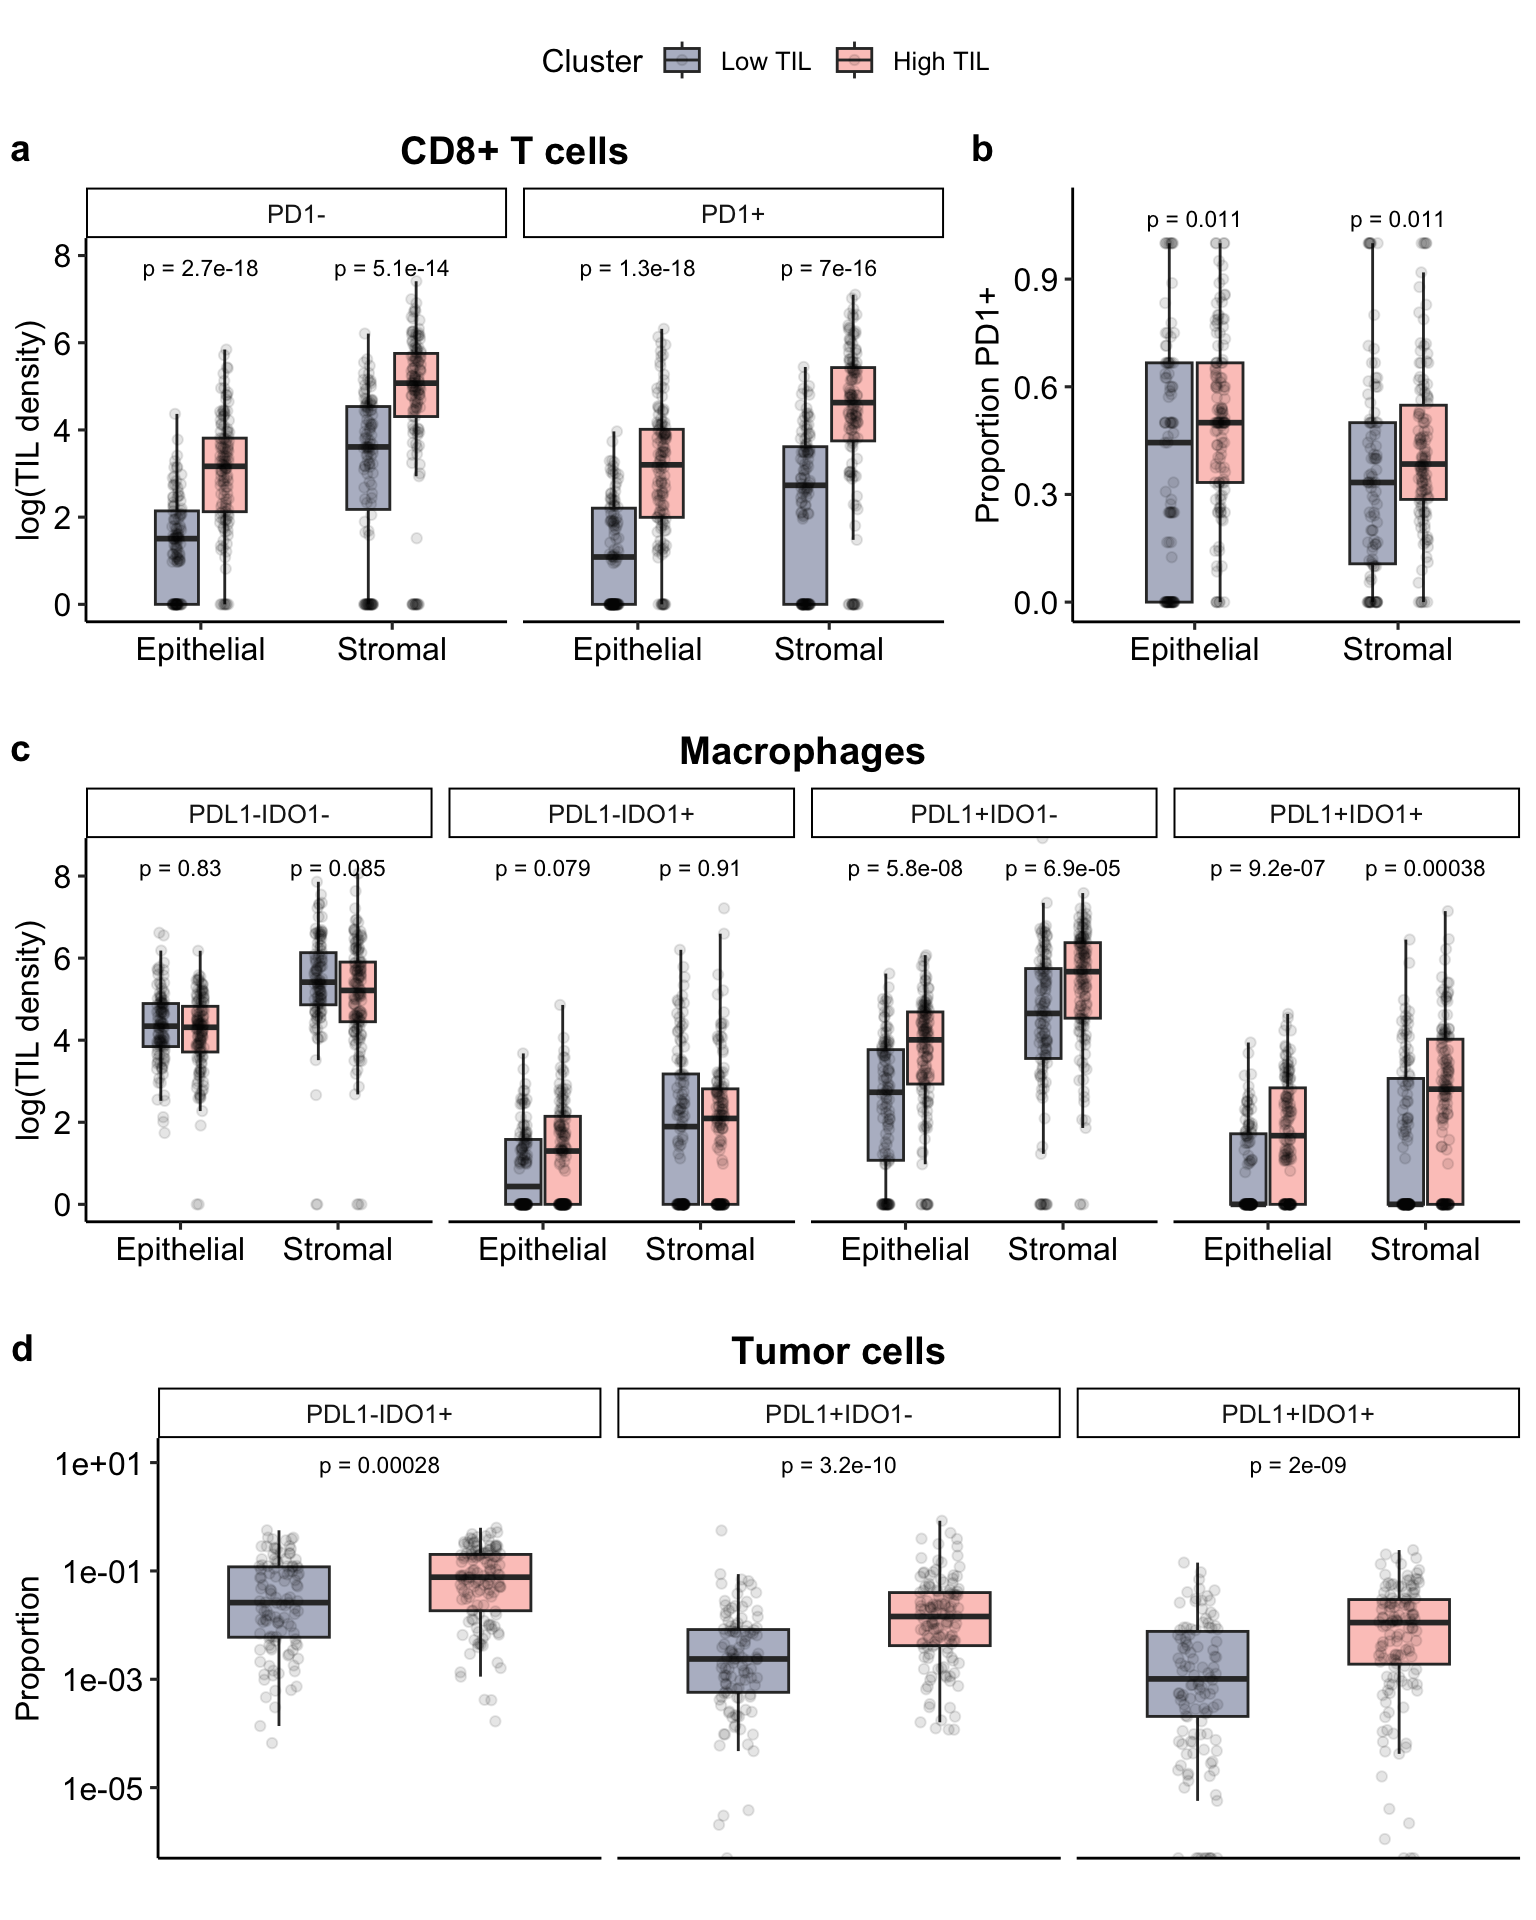

In [ ]:
top_row <- plot_grid(tcyto_densities_plot + theme(legend.position = "none"), pd1pos_prop_plot, labels = c("a", "b"), rel_widths = c(0.5, 0.3), nrow = 1)
